# *GPT*

In [ ]:
import numpy as np
from dataclasses import dataclass
import torch 
import pandas as pd
import torch.nn as nn

import matplotlib.pyplot as plt

In [65]:
@dataclass
class Config:
    n_embd = 128
    block_size = 12 
    batch_size = 32
    height = 64
    width = 64

# *Understanding Normalization Layers*

In [66]:
x2d = torch.randn((Config.batch_size, Config.n_embd))                                # (B, C)  2d data 
x3d =  torch.randn((Config.batch_size, Config.block_size, Config.n_embd))            # (B, T, C) 3d data
x4d = torch.randn((Config.batch_size, Config.n_embd, Config.height, Config.width))   # (B, C, H, W) 4d data

x2d.shape, x3d.shape, x4d.shape

(torch.Size([32, 128]),
 torch.Size([32, 12, 128]),
 torch.Size([32, 128, 64, 64]))

*BN and LN for 2d data*

In [110]:
# bn and ln for 2d data 
bn = nn.BatchNorm1d(Config.n_embd) 
ln = nn.LayerNorm(Config.n_embd) 

# 2d data normalized by bn and ln
x2d_bn = bn(x2d) 
x2d_ln = ln(x2d) 

# 2d data normalized by manuall
x2d_bn_m = (x2d -  x2d.mean(0, keepdim= True) ) / torch.sqrt(x2d.var(0, keepdim= True, unbiased= False) + 1e-5)
x2d_ln_m = ( x2d - x2d.mean(1, keepdim= True) ) / torch.sqrt( x2d.var(1, keepdim= True ,unbiased= False) + 1e-5)

print("is pytorch BN and our BN for 2d are equall?", torch.allclose(x2d_bn, x2d_bn_m))
print("is pytorch LN and our LN for 2d are equall?",torch.allclose(x2d_ln, x2d_ln_m, atol= 1e-7))

is pytorch BN and our BN for 2d are equall? True
is pytorch LN and our LN for 2d are equall? True


*BN and LN for 3d data*

In [111]:
# bn and ln for 3d data
bn3 = nn.BatchNorm1d(Config.n_embd)
ln3 = nn.LayerNorm(Config.n_embd) 

# 3d data normalized by bn and ln
x3d_bn = bn3(x3d.transpose(-2, -1)) 
x3d_ln = ln3(x3d) 

# 3d data normalized by manuall bn and ln
x3d_ln_m = (x3d -  x3d.mean(-1, keepdim=True)) / torch.sqrt(x3d.var(-1, keepdim=True, unbiased= False) + 1e-5) 
x3d_bn_m = (x3d.transpose(-1, -2) - x3d.transpose(-1, -2).mean((0, -1), keepdim= True)) / torch.sqrt(x3d.transpose(-1, -2).var((0, -1), unbiased= False, keepdim= True) + 1e-5)
# x3d_bn_m = (x3d - x3d.mean((0, 1), keepdim= True)) / torch.sqrt(x3d.var((0, 1), unbiased= False, keepdim= True) + 1e-5)

print("is pytorch LN and our LN for 3d data are equall ?", torch.allclose(x3d_ln_m, x3d_ln, atol= 1e-7) )
print('is pytorch BN and our BN for 3d data are equall ?', torch.allclose(x3d_bn, x3d_bn_m, atol= 1e-8))


is pytorch LN and our LN for 3d data are equall ? True
is pytorch BN and our BN for 3d data are equall ? True


*BN and LN for 4d data*

In [112]:
#bn and ln for 4d data
bn4 = nn.BatchNorm2d(Config.n_embd)
ln4 = nn.LayerNorm((Config.n_embd, Config.height, Config.width)) 

# 4d data normalized by bn and ln
x4d_bn = bn4(x4d) 
x4d_ln = ln4(x4d)

# 4d data normalized by manuall bn and ln
x4d_bn_m = (x4d - x4d.mean((0, 2, 3), keepdim= True) ) / torch.sqrt(x4d.var((0, 2, 3), keepdim=True, unbiased= False) + 1e-5)
x4d_ln_m = (x4d - x4d.mean((1, 2, 3), keepdim= True) ) / torch.sqrt(x4d.var((1, 2, 3), keepdim= True, unbiased= False) + 1e-5)


print(f"is pytorch BN and our BN for 4d data are equall ?", torch.allclose(x4d_bn_m, x4d_bn))
print(f"is pytorch LN and our LN for 4d data are equall ?", torch.allclose(x4d_ln_m, x4d_ln))

is pytorch BN and our BN for 4d data are equall ? True
is pytorch LN and our LN for 4d data are equall ? True


# O

In [159]:
class DyT(nn.Module):

    def __init__(self, config):
        super(DyT, self).__init__()

        self.alpha = nn.Parameter(torch.ones(1) * 0.5)
        self.gamma = nn.Parameter(torch.ones(config.n_embd))
        self.beta = nn.Parameter(torch.zeros(config.n_embd))

    def forward(self, x):
        # x is shape of (B, T, C) 
        x = torch.tanh( self.alpha * x) 
        return self.gamma * x + self.beta



In [160]:
x = torch.randn((Config.n_embd))
dyt = DyT(Config)
x.shape

torch.Size([128])

In [ ]:
# normalized x
dyt_x = dyt(x)
ln = nn.LayerNorm(Config.n_embd)
ln_x = ln(x)


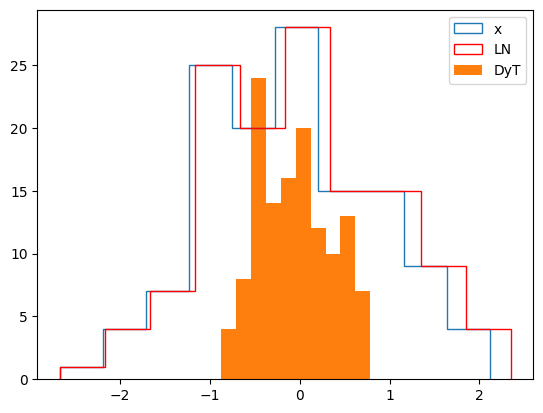

In [ ]:
plt.hist(x, histtype='step')
plt.hist(dyt_x.detach().numpy())
plt.hist(ln_x.detach().numpy(), color='red', histtype='step')
plt.legend(['x', 'LN', 'DyT'])
plt.show()

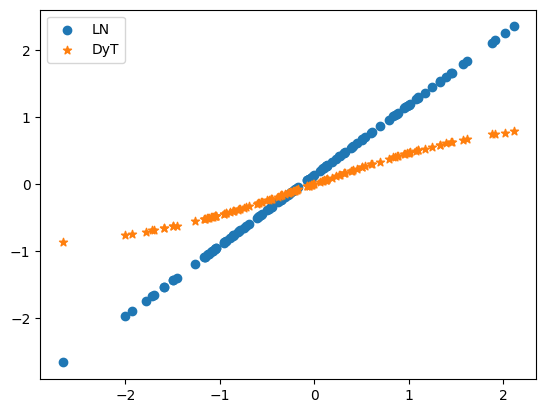

In [144]:
plt.scatter(x, ln_x.detach().numpy())
plt.scatter(x, dyt_x.detach().numpy(), marker='*')
plt.legend(['LN', 'DyT'])
plt.show()